**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [1]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm

In [4]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer, PorterStemmer

In [5]:
import gensim
from gensim.models import Word2Vec

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [7]:
# Set the style for seaborn
sns.set(style="white")

In [8]:
import os
print(os.getcwd())


c:\Users\ruben\Desktop\Universidade\Nova IMS\2nd Semester\Text Mining\Project\Text-Mining-Project\Notebooks


In [9]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

In [10]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [11]:
# Set id as index
df_test.set_index('id', inplace=True)

In [12]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [13]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

In [14]:
df_train["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [15]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

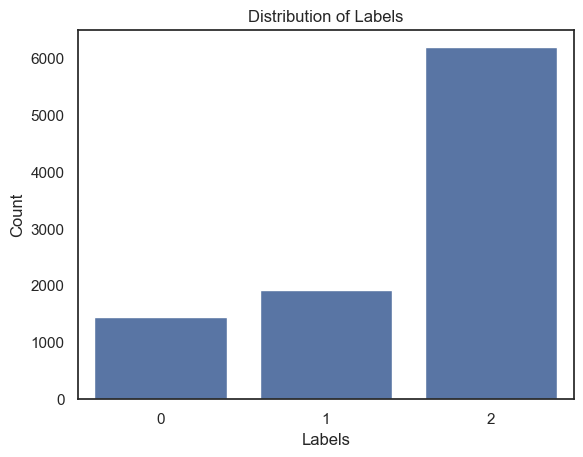

In [16]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

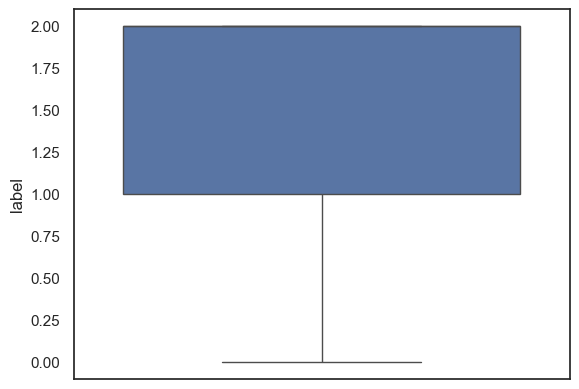

In [17]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

In [18]:
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [19]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

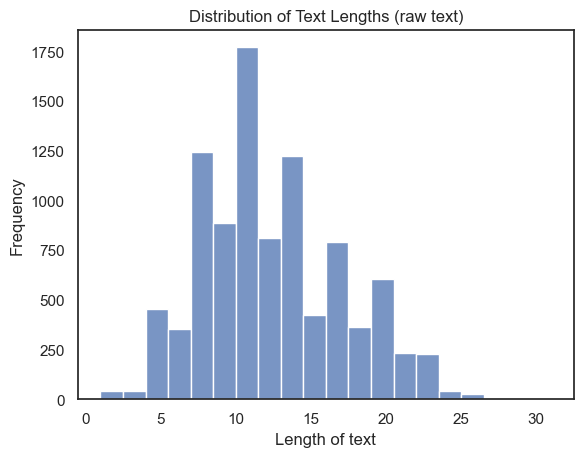

In [20]:
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [21]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

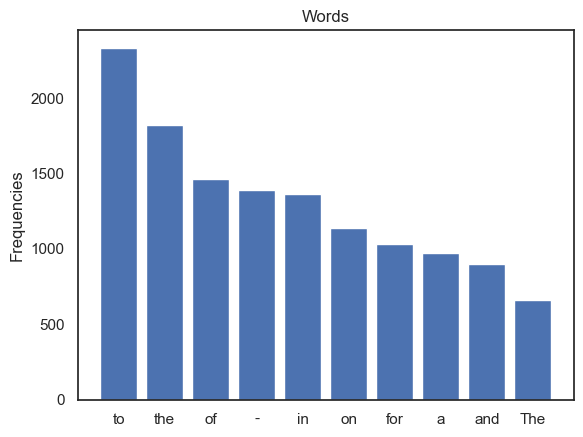

In [22]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

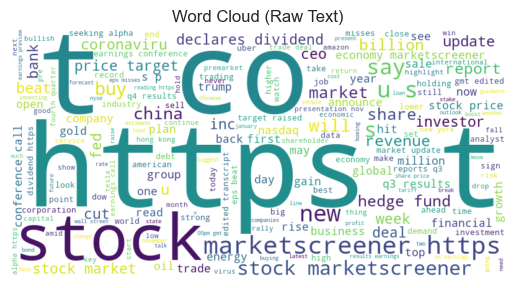

In [23]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

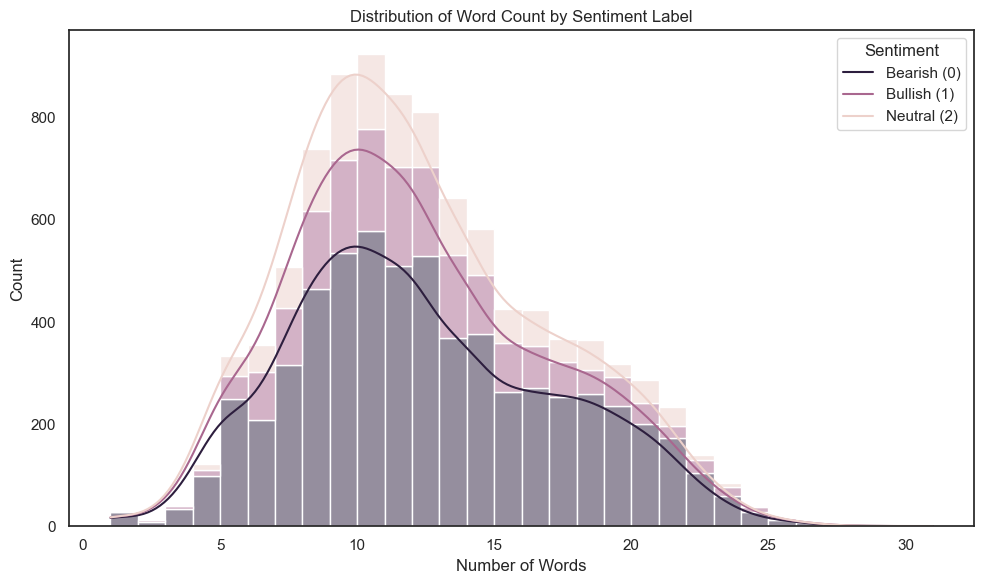

In [24]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

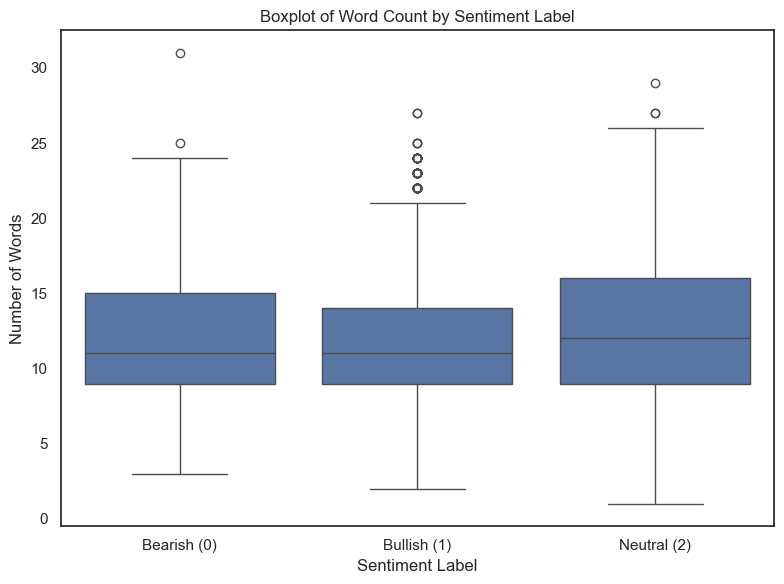

In [25]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [26]:
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [27]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

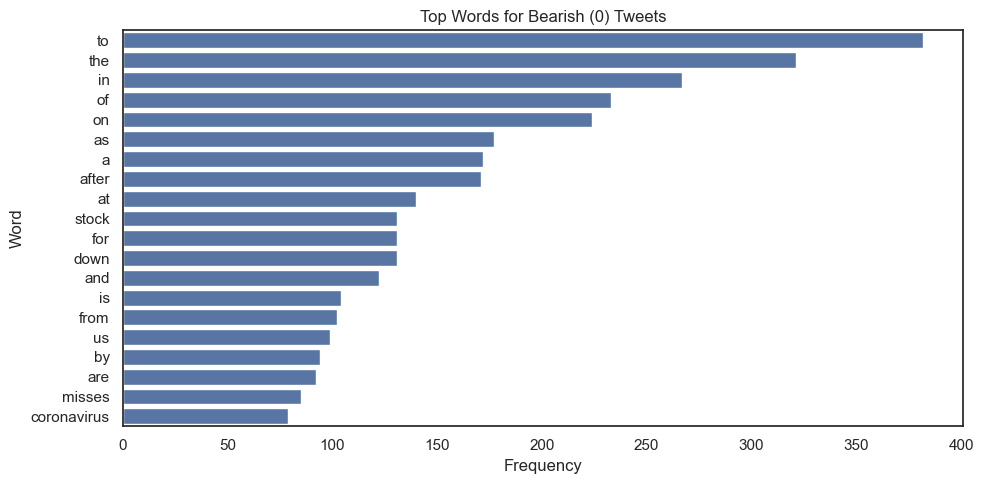

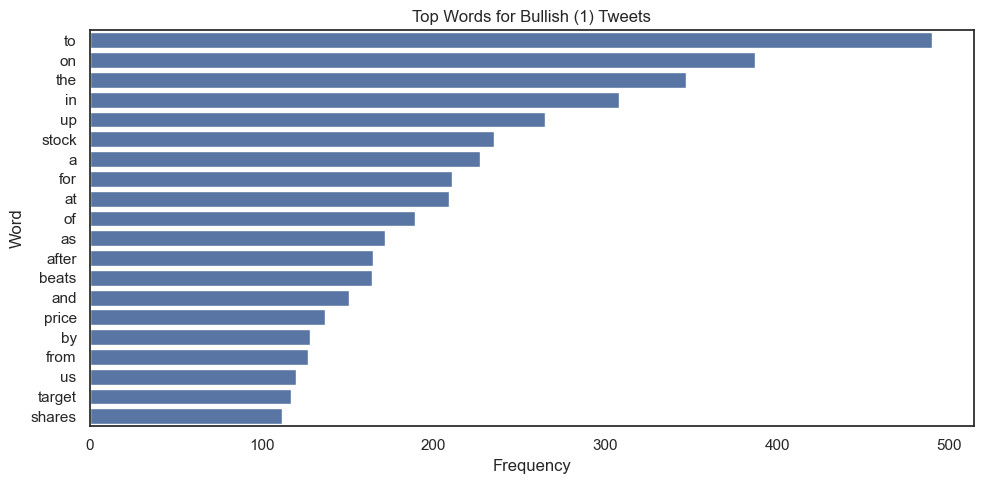

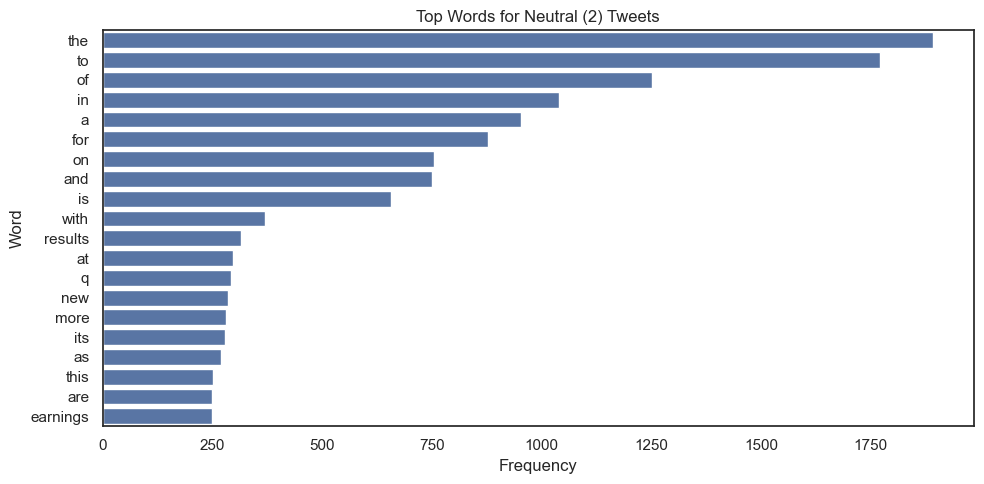

In [28]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [29]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

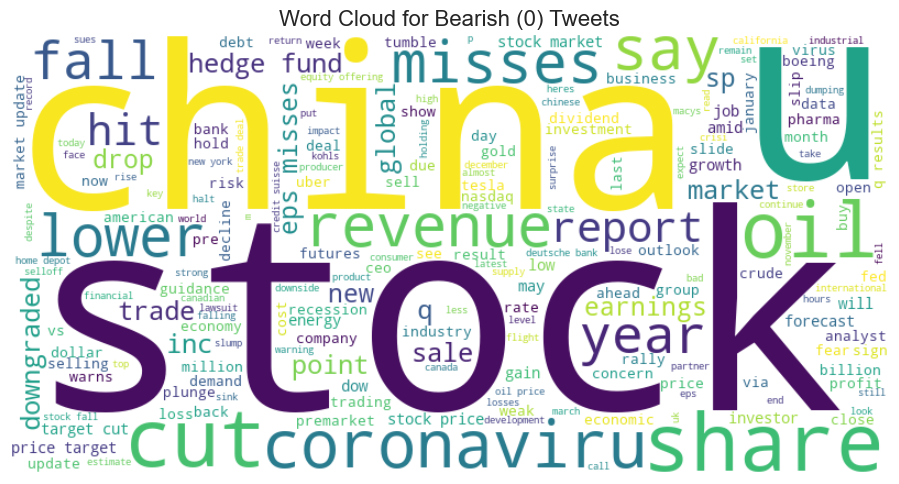

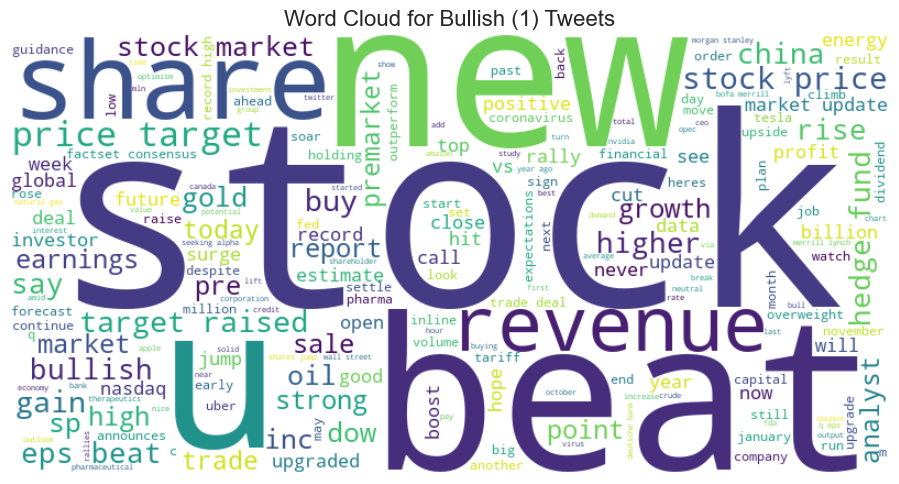

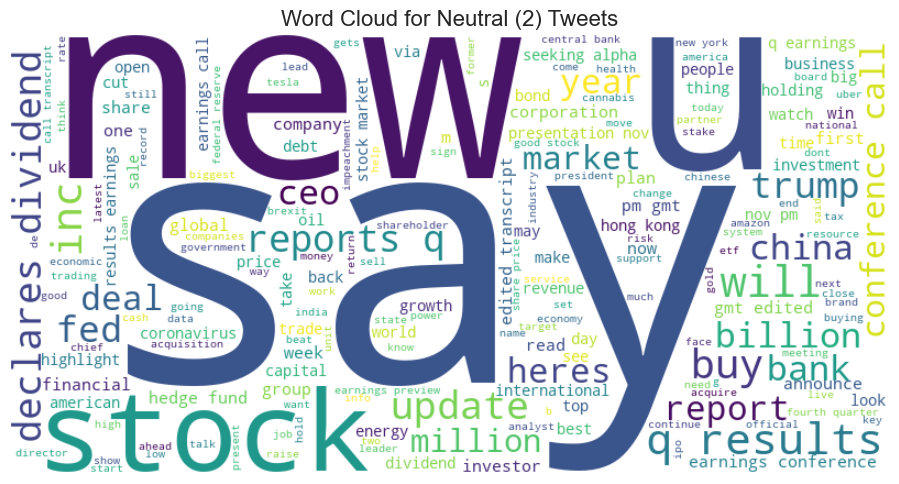

In [30]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

In [31]:
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)

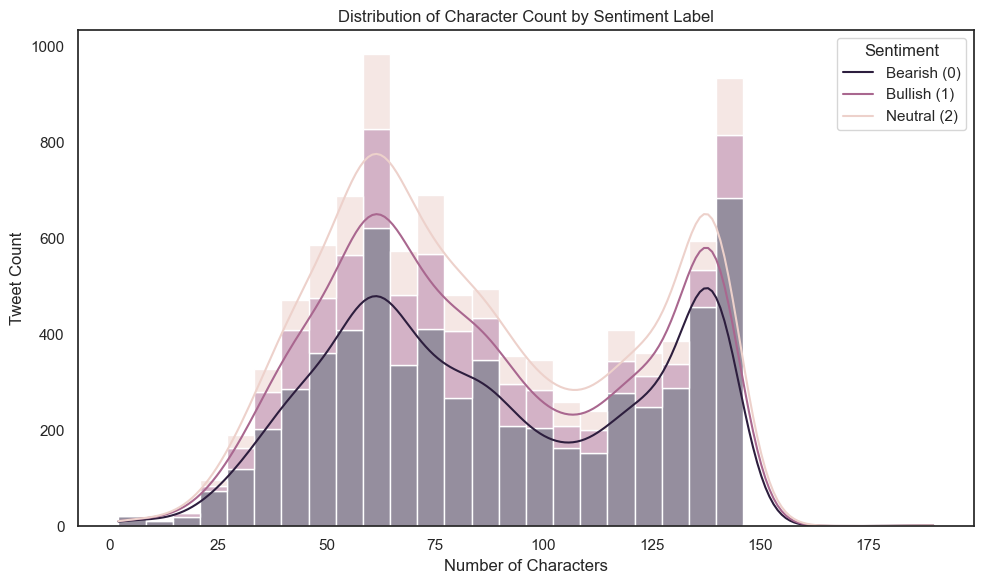

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

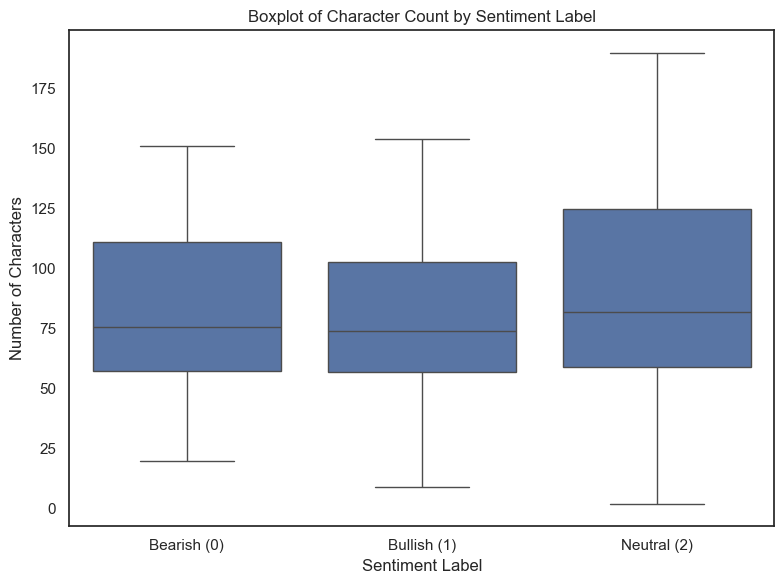

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [34]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [35]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

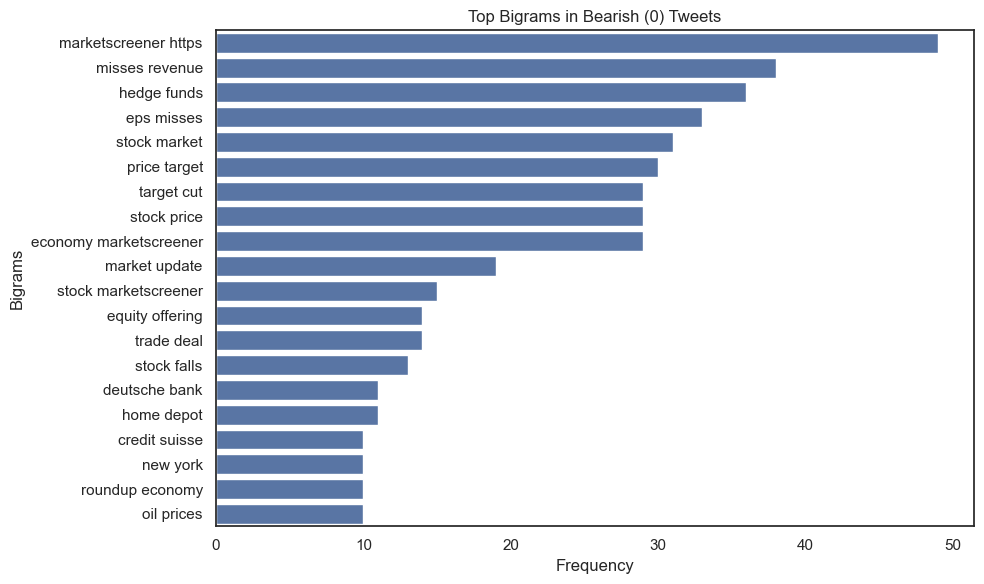

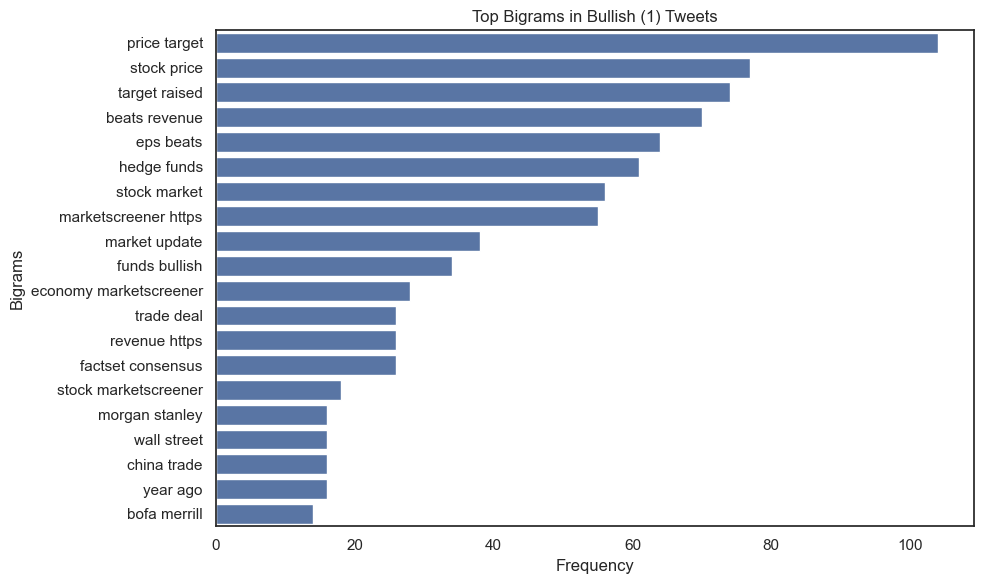

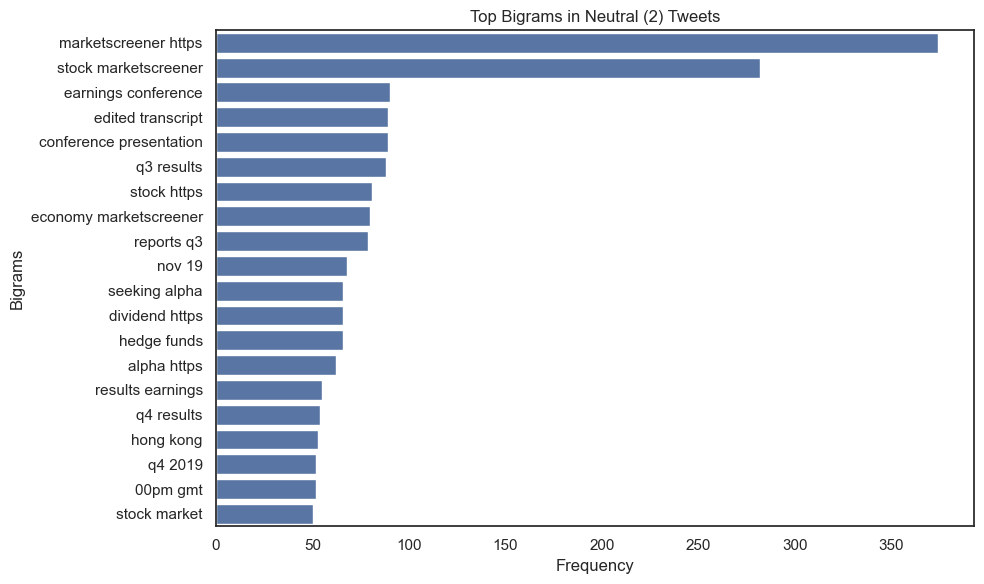

In [36]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

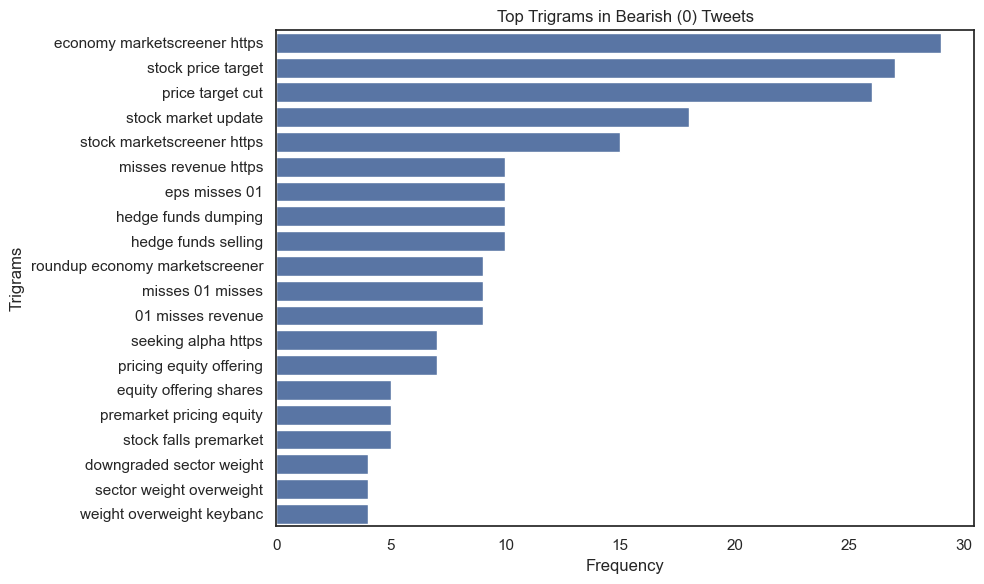

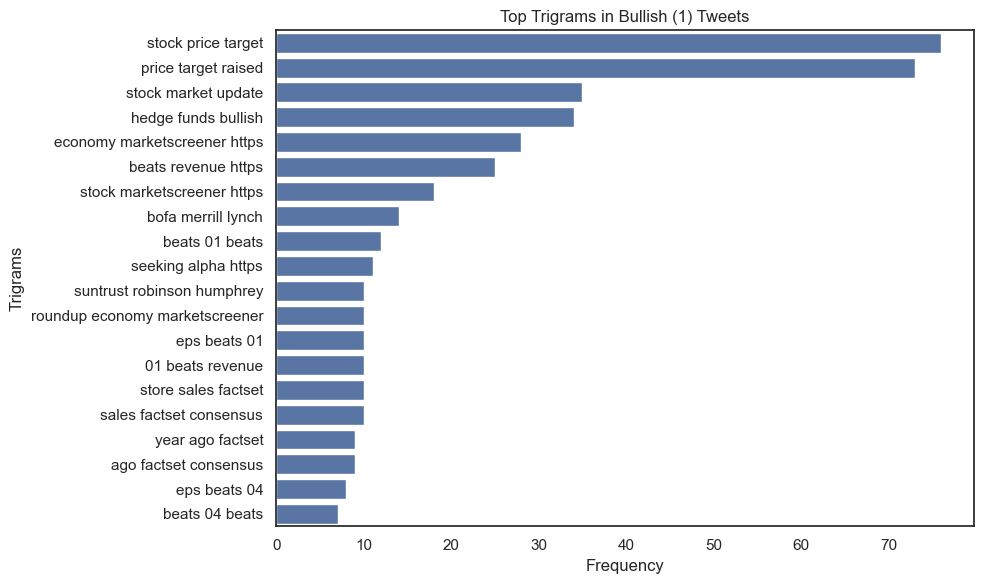

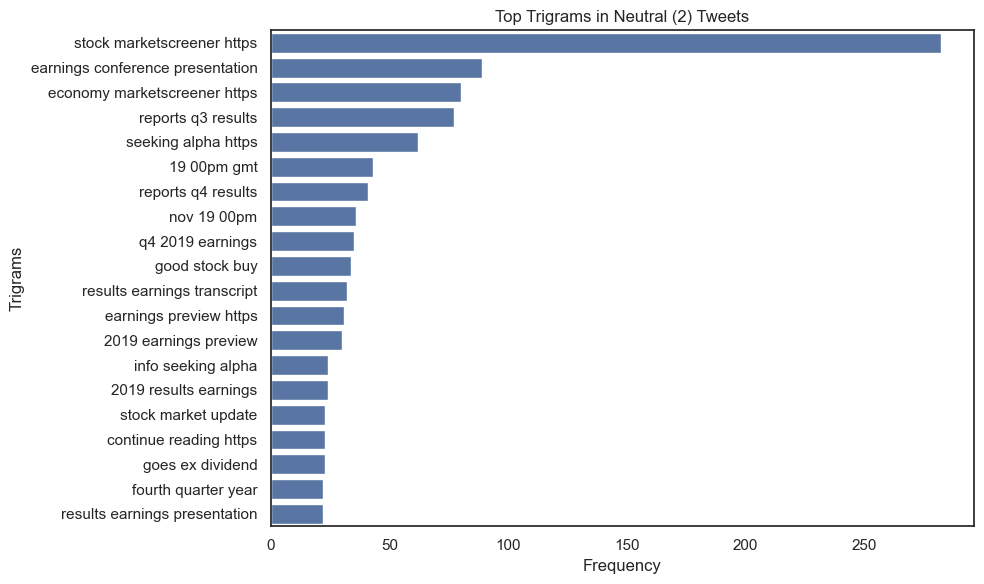

In [37]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

In [38]:
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms

In [39]:
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

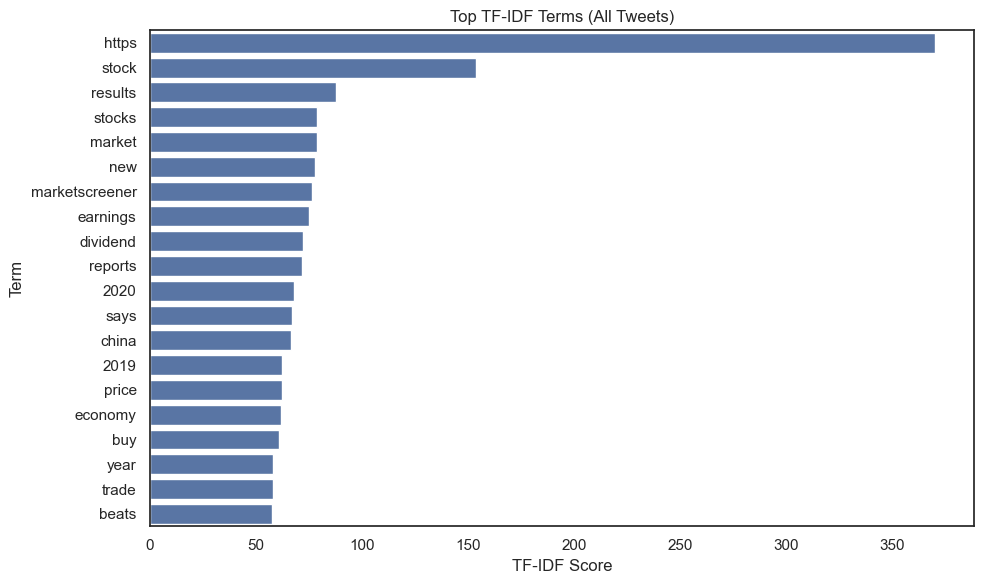

In [40]:
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')

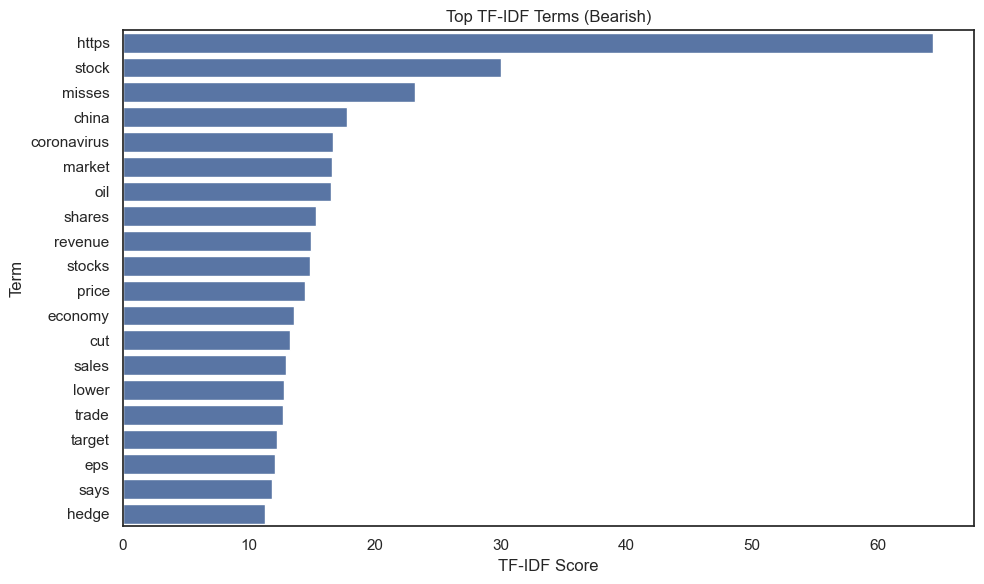

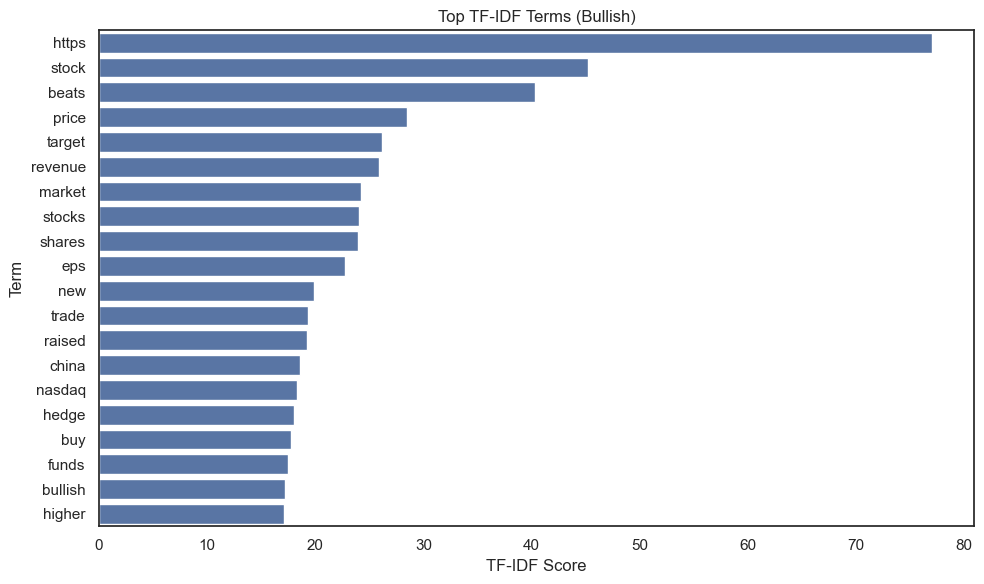

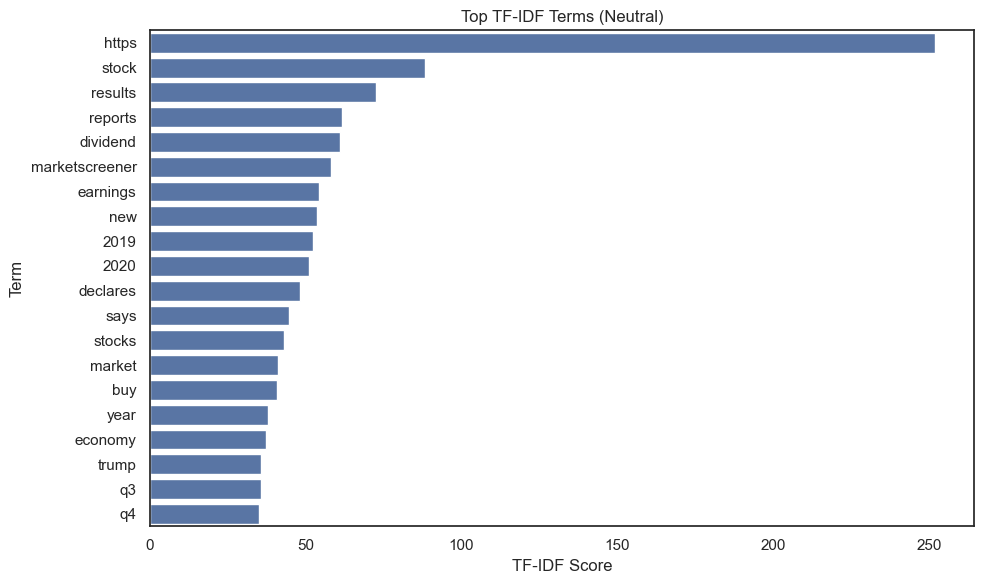

In [41]:
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.20, stratify=df_train['label'], random_state=4)

In [43]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7634, 1909, 7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

In [44]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [46]:
def preprocess_text(text, do_lemmatize=True, do_stem=False):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)                            # Remove mentions and hashtags
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)     # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenization
    tokens = nltk.word_tokenize(text)

    # 4. Stop word removal
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization and Stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if do_stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

In [47]:
X_train_cleaned = X_train.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))

In [48]:
# Check before and after cleaning
print("Original tweet:\n", X_train.iloc[6])
print("Cleaned tweet:\n", X_train_cleaned.iloc[6])

Original tweet:
 What Matters For 'Newly Christened Macro Bulls'. Follow this and any other stock on Seeking Alpha!… https://t.co/kzzahcB8Ue
Cleaned tweet:
 matter newly christened macro bull follow stock seeking alpha


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [49]:
def extract_bow_features(train_texts, test_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer

In [50]:
BoW_X_train, BoW_X_test, bow_vectorizer = extract_bow_features(X_train_cleaned, X_test_cleaned)

In [51]:
term_counts = np.array(BoW_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [52]:
top_terms_df.head(10)

,term,count
10399,stock,662
6534,market,338
9112,report,319
7286,new,317
9555,say,308
8533,price,307
9185,result,283
9816,share,274
3276,earnings,261
5316,inc,240


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [53]:
def extract_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_test, vectorizer

In [54]:
tfidf_X_train, tfidf_X_test, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_test_cleaned)

In [55]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('fiveyear', 9.247351037092788),
 ('fix', 7.9945880685974196),
 ('fixed', 8.331060305218632),
 ('fixedincome', 9.247351037092788),
 ('fixing', 8.841885928984624),
 ('fizz', 9.247351037092788),
 ('fizzle', 8.841885928984624),
 ('fj', 9.247351037092788),
 ('fl', 7.9945880685974196),
 ('flag', 7.9945880685974196)]

<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [56]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [57]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]

In [58]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [59]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>

In [60]:
# %pip install tf-keras

from transformers import (
    DistilBertTokenizer,
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

import torch

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:

# Load tokenizer and model
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')


# 1) Disable dropout
bert_model.eval()

# 2) Batch-embed helper
def transformer_embeddings(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = bert_tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        # out.last_hidden_state: (batch, seq_len, hidden_dim)
        mask   = enc.attention_mask.unsqueeze(-1)           # (batch, seq_len, 1)
        summed = (out.last_hidden_state * mask).sum(dim=1)   # sum over seq_len
        counts = mask.sum(dim=1)                            # number of real tokens
        embs   = (summed / counts).cpu().numpy()            # mean‐pooled vectors
        all_embs.append(embs)
    return np.vstack(all_embs)

# 3) Embed your splits
X_train_transformer = transformer_embeddings(X_train_cleaned.tolist())
X_test_transformer  = transformer_embeddings(X_test_cleaned.tolist())

<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>

Meta/Facebook pre-trained English word-vector model

<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>

Sentence-Transformer (SBERT) for Financial Sentences

https://huggingface.co/ohsuz/k-finance-sentence-transformer

In [62]:
# !pip install -U sentence-transformers

In [63]:
from transformers import AutoTokenizer, AutoModel
import torch

from sentence_transformers import SentenceTransformer

# Load the finance-tuned SBERT
sbert = SentenceTransformer("ohsuz/k-finance-sentence-transformer")

# Encode
sbert_X_train = sbert.encode(X_train.tolist(), show_progress_bar=True)
sbert_X_test  = sbert.encode(X_test.tolist(),  show_progress_bar=True)

Batches: 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


# CHLOE 


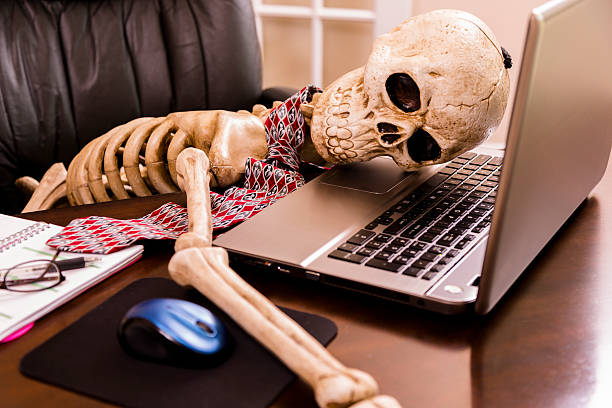

<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

faz o lstm

fine tune da melhor combinação de modelos

encoder decoder

notebook final

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>

In [64]:
# import pandas as 
# from sklearn.metrics import precision_score, recall_score, f1_score

# # 1) Define your results table with overall + per-label columns
# results_columns = [
#     "Model", "Representation",
#     # Overall
#     "Train_Prec", "Train_Rec", "Train_F1",
#     "Val_Prec",   "Val_Rec",   "Val_F1",
#     # Per-label F1
#     "Train_F1_0", "Train_F1_1", "Train_F1_2",
#     "Val_F1_0",   "Val_F1_1",   "Val_F1_2",
# ]
# results = pd.DataFrame(columns=results_columns)

# # 2) log_result unpacks both overall and per-label metrics
# def log_result(
#     model_name: str,
#     feat_name: str,
#     train_prec: float, train_rec: float, train_f1: float,
#     val_prec: float,   val_rec: float,   val_f1: float,
#     train_f1_arr=None,  # array-like length=3
#     val_f1_arr=None,    # array-like length=3
# ):
#     global results
#     row = {
#         "Model": model_name,
#         "Representation": feat_name,
#         # overall
#         "Train_Prec": train_prec,
#         "Train_Rec":  train_rec,
#         "Train_F1":   train_f1,
#         "Val_Prec":   val_prec,
#         "Val_Rec":    val_rec,
#         "Val_F1":     val_f1,
#         # per-label F1
#         "Train_F1_0": train_f1_arr[0],
#         "Train_F1_1": train_f1_arr[1],
#         "Train_F1_2": train_f1_arr[2],
#         "Val_F1_0":   val_f1_arr[0],
#         "Val_F1_1":   val_f1_arr[1],
#         "Val_F1_2":   val_f1_arr[2],
#     }
#     results.loc[len(results)] = row

# # 3) New evaluate_and_log computes everything
# def evaluate_and_log(
#     model_name, feat_name, model, X_tr, y_tr, X_te, y_te
# ):
#     # predict
#     y_tr_pred = model.predict(X_tr)
#     y_te_pred = model.predict(X_te)

#     # overall metrics
#     tr_prec = precision_score(y_tr, y_tr_pred, average="macro")
#     tr_rec  = recall_score(   y_tr, y_tr_pred, average="macro")
#     tr_f1   = f1_score(       y_tr, y_tr_pred, average="macro")

#     val_prec = precision_score(y_te, y_te_pred, average="macro")
#     val_rec  = recall_score(   y_te, y_te_pred, average="macro")
#     val_f1   = f1_score(       y_te, y_te_pred, average="macro")

#     # F1score for labels 0,1,2
#     tr_f1_arr  = f1_score(y_tr, y_tr_pred, average=None, labels=[0,1,2])
#     val_f1_arr = f1_score(y_te, y_te_pred, average=None, labels=[0,1,2])

#     # log everything
#     log_result(
#         model_name=model_name,
#         feat_name=feat_name,
#         train_prec=tr_prec,
#         train_rec=tr_rec,
#         train_f1=tr_f1,
#         val_prec=val_prec,
#         val_rec=val_rec,
#         val_f1=val_f1,
#         train_f1_arr=tr_f1_arr,
#         val_f1_arr=val_f1_arr,
#     )

# # function to show the results
# def show():
#     print(results.to_string(index=False))


Remove the per label f1 score

In [65]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# 1) Define your results table with training metrics first, then validation
results_columns = [
    "Model", "Representation",
    # --- Overall Train Metrics ---
    "Train_Prec", "Train_Rec", "Train_F1",
    # --- Per-Label Train F1 ---
    "Train_F1_0", "Train_F1_1", "Train_F1_2",
    # --- Overall Val Metrics ---
    "Val_Prec",   "Val_Rec",   "Val_F1",
    # --- Per-Label Val F1 ---
    "Val_F1_0",   "Val_F1_1",   "Val_F1_2",
]
results = pd.DataFrame(columns=results_columns)

# 2) log_result unpacks both overall and per-label metrics
def log_result(
    model_name: str,
    feat_name: str,
    # overall
    train_prec: float, train_rec: float, train_f1: float,
    # per-label arrays
    train_f1_arr,  # array-like length=3
    # validation overall
    val_prec: float,   val_rec: float,   val_f1: float,
    # validation per-label
    val_f1_arr,    # array-like length=3
):
    global results
    row = {
        "Model": model_name,
        "Representation": feat_name,
        # --- Overall Train ---
        "Train_Prec": train_prec,
        "Train_Rec":  train_rec,
        "Train_F1":   train_f1,
        # --- Per-Label Train ---
        "Train_F1_0": train_f1_arr[0],
        "Train_F1_1": train_f1_arr[1],
        "Train_F1_2": train_f1_arr[2],
        # --- Overall Val ---
        "Val_Prec":   val_prec,
        "Val_Rec":    val_rec,
        "Val_F1":     val_f1,
        # --- Per-Label Val ---
        "Val_F1_0":   val_f1_arr[0],
        "Val_F1_1":   val_f1_arr[1],
        "Val_F1_2":   val_f1_arr[2],
    }
    results.loc[len(results)] = row

# 3) New evaluate_and_log computes everything
def evaluate_and_log(
    model_name, feat_name, model, X_tr, y_tr, X_te, y_te
):
    # --- Predictions ---
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # --- Overall Train Metrics ---
    tr_prec = precision_score(y_tr, y_tr_pred, average="macro")
    tr_rec  = recall_score(   y_tr, y_tr_pred, average="macro")
    tr_f1   = f1_score(       y_tr, y_tr_pred, average="macro")

    # --- Per-Label Train F1 ---
    tr_f1_arr  = f1_score(y_tr, y_tr_pred, average=None, labels=[0,1,2])

    # --- Overall Val Metrics ---
    val_prec = precision_score(y_te, y_te_pred, average="macro")
    val_rec  = recall_score(   y_te, y_te_pred, average="macro")
    val_f1   = f1_score(       y_te, y_te_pred, average="macro")

    # --- Per-Label Val F1 ---
    val_f1_arr = f1_score(y_te, y_te_pred, average=None, labels=[0,1,2])

    # --- Log Everything ---
    log_result(
        model_name=model_name,
        feat_name=feat_name,
        train_prec=tr_prec,
        train_rec=tr_rec,
        train_f1=tr_f1,
        train_f1_arr=tr_f1_arr,
        val_prec=val_prec,
        val_rec=val_rec,
        val_f1=val_f1,
        val_f1_arr=val_f1_arr,
    )

# 4) show() to inspect
def show():
    print(results.to_string(index=False))


In [66]:
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

### **WITH BOW**

In [67]:
BoW_knn = KNeighborsClassifier(n_neighbors=5)
BoW_knn.fit(BoW_X_train, y_train)
y_pred = BoW_knn.predict(BoW_X_test)

In [68]:
evaluate_classification("BoW", y_test, y_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7003666841278157
Precision (macro): 0.7691505806321756
Recall (macro): 0.435767259978425
F1 Score (macro): 0.44566485868298517

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.8049    0.1146    0.2006       288
           1     0.8105    0.2000    0.3208       385
           2     0.6920    0.9927    0.8156      1236

    accuracy                         0.7004      1909
   macro avg     0.7692    0.4358    0.4457      1909
weighted avg     0.7330    0.7004    0.6230      1909



In [69]:
evaluate_and_log(
    model_name="KNN",
    feat_name="BoW",
    model=BoW_knn,
    X_tr=BoW_X_train,
    y_tr=y_train,
    X_te=BoW_X_test,
    y_te=y_test
)

### **WITH TF-IDF**

In [70]:
tfidf_knn = KNeighborsClassifier(n_neighbors=5)
tfidf_knn.fit(tfidf_X_train, y_train)
y_pred = tfidf_knn.predict(tfidf_X_test)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ruben\.conda\envs\DeepLearnin

In [71]:
evaluate_classification("TF-IDF", y_test, y_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.6762702985856469
Precision (macro): 0.7278040308574659
Recall (macro): 0.3885728528932413
F1 Score (macro): 0.3685958928529174

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6667    0.0694    0.1258       288
           1     0.8444    0.0987    0.1767       385
           2     0.6723    0.9976    0.8033      1236

    accuracy                         0.6763      1909
   macro avg     0.7278    0.3886    0.3686      1909
weighted avg     0.7062    0.6763    0.5747      1909



In [72]:
evaluate_and_log(
    model_name="KNN",
    feat_name="TF-IDF",
    model=tfidf_knn,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)

### **WITH WORD2VEC**

In [73]:
word2vec_knn = KNeighborsClassifier(n_neighbors=5)
word2vec_knn.fit(word2vec_X_train, y_train)
y_pred = word2vec_knn.predict(word2vec_X_test)

In [74]:
evaluate_classification("Word2Vec", y_test, y_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.6165531691985333
Precision (macro): 0.46706875575923196
Recall (macro): 0.45589056305075726
F1 Score (macro): 0.4600298167020081

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.2821    0.2292    0.2529       288
           1     0.3807    0.3481    0.3636       385
           2     0.7385    0.7905    0.7636      1236

    accuracy                         0.6166      1909
   macro avg     0.4671    0.4559    0.4600      1909
weighted avg     0.5975    0.6166    0.6059      1909



In [75]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Word2Vec",
    model=word2vec_knn,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_test,
    y_te=y_test
)

### **BERT Transformer**

In [76]:
# WITH Transformer (BERT mean-pooled)
knn_bert = KNeighborsClassifier(n_neighbors=5)
knn_bert.fit(X_train_transformer, y_train)
y_pred = knn_bert.predict(X_test_transformer)

evaluate_classification("Transformer BERT", y_test, y_pred)
evaluate_and_log(
    model_name="KNN",
    feat_name="Transformer BERT",
    model=knn_bert,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)

Evaluation metrics with Transformer BERT features.
Accuracy: 0.678365636458879
Precision (macro): 0.566929750638071
Recall (macro): 0.5693503166197341
F1 Score (macro): 0.5677463957115262

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.4270    0.4062    0.4164       288
           1     0.4654    0.5065    0.4851       385
           2     0.8084    0.7953    0.8018      1236

    accuracy                         0.6784      1909
   macro avg     0.5669    0.5694    0.5677      1909
weighted avg     0.6817    0.6784    0.6798      1909



### **Setence BERT**

In [77]:
knn_sbert = KNeighborsClassifier(n_neighbors=5)
knn_sbert.fit(sbert_X_train, y_train)
y_pred = knn_sbert.predict(sbert_X_test)
evaluate_classification("Sentence-BERT", y_test, y_pred)
evaluate_and_log(
    model_name="KNN",
    feat_name="Sentence BERT",
    model=knn_sbert,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_test,
    y_te=y_test
)

Evaluation metrics with Sentence-BERT features.
Accuracy: 0.6579360921948664
Precision (macro): 0.5241105089429041
Recall (macro): 0.5098272951428292
F1 Score (macro): 0.5158020550877693

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.3435    0.3125    0.3273       288
           1     0.4567    0.3974    0.4250       385
           2     0.7721    0.8196    0.7951      1236

    accuracy                         0.6579      1909
   macro avg     0.5241    0.5098    0.5158      1909
weighted avg     0.6438    0.6579    0.6499      1909



### Grid Search/CV fine tune best model

In [78]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [79]:
# Feature and label
X = X_train_transformer
y = y_train

# Define parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [80]:
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

knn_grid.fit(X, y)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro', verbose=2)

In [81]:
best_knn = knn_grid.best_estimator_
print("Best params:", knn_grid.best_params_)
print("Best CV F1 macro score:", knn_grid.best_score_)

# Predict on test
y_pred = best_knn.predict(X_test_transformer)

# Standard evaluation printout (optional)
evaluate_classification("Transformer BERT CV", y_test, y_pred)


Best params: {'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Best CV F1 macro score: 0.592532674910792
Evaluation metrics with Transformer BERT CV features.
Accuracy: 0.7276060764798323
Precision (macro): 0.6381779034068235
Recall (macro): 0.574510447750739
F1 Score (macro): 0.5959153476237758

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5833    0.3646    0.4487       288
           1     0.5408    0.4649    0.5000       385
           2     0.7904    0.8940    0.8390      1236

    accuracy                         0.7276      1909
   macro avg     0.6382    0.5745    0.5959      1909
weighted avg     0.7088    0.7276    0.7118      1909



In [82]:
evaluate_and_log(
    model_name="KNN CV-GS",
    feat_name="Transformer BERT",
    model=best_knn,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)


## 6.2. Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

### **WITH BOW**

In [84]:
BoW_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
BoW_lg.fit(BoW_X_train, y_train)
y_pred = BoW_lg.predict(BoW_X_test)

In [85]:
evaluate_classification("BoW/Lg", y_test, y_pred)

Evaluation metrics with BoW/Lg features.
Accuracy: 0.784704033525406
Precision (macro): 0.7292875918241347
Recall (macro): 0.6499568033548616
F1 Score (macro): 0.6787904483080628

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6772    0.4444    0.5367       288
           1     0.6894    0.5766    0.6280       385
           2     0.8212    0.9288    0.8717      1236

    accuracy                         0.7847      1909
   macro avg     0.7293    0.6500    0.6788      1909
weighted avg     0.7729    0.7847    0.7720      1909



In [86]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="BoW",
    model=BoW_lg,
    X_tr=BoW_X_train,
    y_tr=y_train,
    X_te=BoW_X_test,
    y_te=y_test
)

### **WITH TF-IDF**

In [87]:
tfidf_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
tfidf_lg.fit(tfidf_X_train, y_train)
y_pred = tfidf_lg.predict(tfidf_X_test)

In [88]:
evaluate_classification("TF-IDF/Lg", y_test, y_pred)

Evaluation metrics with TF-IDF/Lg features.
Accuracy: 0.7689889994761655
Precision (macro): 0.7460669238674833
Recall (macro): 0.5914029336359433
F1 Score (macro): 0.6321409346770083

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7385    0.3333    0.4593       288
           1     0.7198    0.4805    0.5763       385
           2     0.7799    0.9604    0.8608      1236

    accuracy                         0.7690      1909
   macro avg     0.7461    0.5914    0.6321      1909
weighted avg     0.7615    0.7690    0.7428      1909



In [89]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="TF-IDF",
    model=tfidf_lg,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)

### **WITH WORD2VEC**

In [90]:
word2vec_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
word2vec_lg.fit(word2vec_X_train, y_train)
y_pred = word2vec_lg.predict(word2vec_X_test)

In [91]:
evaluate_classification("Word2Vec/Lg", y_test, y_pred)

Evaluation metrics with Word2Vec/Lg features.
Accuracy: 0.6595075955997904
Precision (macro): 0.381453578138661
Recall (macro): 0.3675534821165889
F1 Score (macro): 0.3300042145323588

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4747    0.1221    0.1942       385
           2     0.6696    0.9806    0.7958      1236

    accuracy                         0.6595      1909
   macro avg     0.3815    0.3676    0.3300      1909
weighted avg     0.5293    0.6595    0.5544      1909



c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [92]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Word2Vec",
    model=word2vec_lg,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_test,
    y_te=y_test
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).

### **BERT Transformer**

In [93]:
# WITH Transformer (BERT mean-pooled)
lg_bert = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lg_bert.fit(X_train_transformer, y_train)
y_pred = lg_bert.predict(X_test_transformer)

evaluate_classification("Transformer BERT/Lg", y_test, y_pred)
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Transformer BERT",
    model=lg_bert,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)

Evaluation metrics with Transformer BERT/Lg features.
Accuracy: 0.7349397590361446
Precision (macro): 0.6459760451220952
Recall (macro): 0.5925282938025657
F1 Score (macro): 0.6127464224711369

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5476    0.3993    0.4618       288
           1     0.5949    0.4883    0.5364       385
           2     0.7954    0.8900    0.8400      1236

    accuracy                         0.7349      1909
   macro avg     0.6460    0.5925    0.6127      1909
weighted avg     0.7176    0.7349    0.7217      1909



### **Setence BERT**

In [94]:
lg_SBERT = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lg_SBERT.fit(sbert_X_train, y_train)
y_pred = lg_SBERT.predict(sbert_X_test)
evaluate_classification("SentenceBert", y_test, y_pred)
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Sequence BERT",
    model=lg_SBERT,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_test,
    y_te=y_test
)

Evaluation metrics with SentenceBert features.
Accuracy: 0.749083289680461
Precision (macro): 0.6615783611408307
Recall (macro): 0.6241860059214428
F1 Score (macro): 0.6393326735192929

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5656    0.4340    0.4912       288
           1     0.5994    0.5558    0.5768       385
           2     0.8197    0.8827    0.8500      1236

    accuracy                         0.7491      1909
   macro avg     0.6616    0.6242    0.6393      1909
weighted avg     0.7369    0.7491    0.7408      1909



### Fine tune the best model

in this case its bow

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

Search space

In [96]:
# Choose feature representation
X = BoW_X_train  
y = y_train

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],               # Regularization strength
    'penalty': ['l2'],                    # Use 'l1' if using solver='liblinear'
    'solver': ['liblinear', 'saga'],      # Solvers that support l1 and l2
    'max_iter': [500, 1000]
}

# Stratified K-Fold to preserve label distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Grid search

In [97]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(n_jobs=-1, random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',    # You can change this to 'accuracy', 'recall_macro', etc.
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X, y)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000],
                         'penalty': ['l2'], 'solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='f1_macro', verbose=2)

best model

In [98]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Macro Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_


Best Parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 Macro Score: 0.6869338293589198


storing the results

In [99]:
y_pred = best_model.predict(BoW_X_test)
print(classification_report(y_test, y_pred))

evaluate_classification("BoW/Lg-CV", y_test, y_pred)

evaluate_and_log(
    model_name="Logistic Regression CV-GS",
    feat_name="BoW",
    model=best_model,
    X_tr=X,
    y_tr=y,
    X_te=BoW_X_test,
    y_te=y_test
)

              precision    recall  f1-score   support

           0       0.65      0.50      0.56       288
           1       0.70      0.63      0.66       385
           2       0.84      0.91      0.87      1236

    accuracy                           0.79      1909
   macro avg       0.73      0.68      0.70      1909
weighted avg       0.78      0.79      0.78      1909

Evaluation metrics with BoW/Lg-CV features.
Accuracy: 0.7909900471451021
Precision (macro): 0.7285091567696628
Recall (macro): 0.6790272407384057
F1 Score (macro): 0.6993842154996792

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6471    0.4965    0.5619       288
           1     0.7003    0.6312    0.6639       385
           2     0.8382    0.9094    0.8723      1236

    accuracy                         0.7910      1909
   macro avg     0.7285    0.6790    0.6994      1909
weighted avg     0.7815    0.7910    0.7835      1909



## 6.3. MLP

In [100]:
# import mlpc
from sklearn.neural_network import MLPClassifier

In [101]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000,          
    random_state=42,
    early_stopping=True,
    verbose=True
)

### **WITH BOW**

In [102]:
Bow_mlp = mlp_model
Bow_mlp.fit(BoW_X_train, y_train)
y_pred = Bow_mlp.predict(BoW_X_test)

Iteration 1, loss = 0.87506622
Validation score: 0.696335
Iteration 2, loss = 0.51437341
Validation score: 0.802356
Iteration 3, loss = 0.21228783
Validation score: 0.801047
Iteration 4, loss = 0.06388018
Validation score: 0.804974
Iteration 5, loss = 0.02642732
Validation score: 0.795812
Iteration 6, loss = 0.01575789
Validation score: 0.785340
Iteration 7, loss = 0.01176062
Validation score: 0.786649
Iteration 8, loss = 0.00993390
Validation score: 0.784031
Iteration 9, loss = 0.00969025
Validation score: 0.786649
Iteration 10, loss = 0.00691928
Validation score: 0.785340
Iteration 11, loss = 0.00684488
Validation score: 0.780105
Iteration 12, loss = 0.00673583
Validation score: 0.782723
Iteration 13, loss = 0.00584460
Validation score: 0.780105
Iteration 14, loss = 0.00564599
Validation score: 0.785340
Iteration 15, loss = 0.00468479
Validation score: 0.780105
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [103]:
evaluate_classification("BoW/Mlp", y_test, y_pred)

Evaluation metrics with BoW/Mlp features.
Accuracy: 0.7878470403352541
Precision (macro): 0.722100416606402
Recall (macro): 0.6682274081545927
F1 Score (macro): 0.6895166335674981

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6381    0.4653    0.5382       288
           1     0.6925    0.6260    0.6576       385
           2     0.8357    0.9134    0.8728      1236

    accuracy                         0.7878      1909
   macro avg     0.7221    0.6682    0.6895      1909
weighted avg     0.7770    0.7878    0.7789      1909



In [104]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="BoW",
    model=Bow_mlp,
    X_tr=BoW_X_train,
    y_tr=y_train,
    X_te=BoW_X_test,
    y_te=y_test
)

### **WITH TF-IDF**

In [105]:
tfidf_mlp = mlp_model
tfidf_mlp.fit(tfidf_X_train, y_train)
y_pred = tfidf_mlp.predict(tfidf_X_test)

Iteration 1, loss = 0.92914522
Validation score: 0.660995
Iteration 2, loss = 0.64910280
Validation score: 0.769634
Iteration 3, loss = 0.35780320
Validation score: 0.802356
Iteration 4, loss = 0.13918204
Validation score: 0.795812
Iteration 5, loss = 0.05754057
Validation score: 0.782723
Iteration 6, loss = 0.03070151
Validation score: 0.767016
Iteration 7, loss = 0.02035615
Validation score: 0.773560
Iteration 8, loss = 0.01358903
Validation score: 0.770942
Iteration 9, loss = 0.01184915
Validation score: 0.778796
Iteration 10, loss = 0.00919779
Validation score: 0.765707
Iteration 11, loss = 0.00865471
Validation score: 0.770942
Iteration 12, loss = 0.00815025
Validation score: 0.768325
Iteration 13, loss = 0.00696287
Validation score: 0.769634
Iteration 14, loss = 0.00636114
Validation score: 0.769634
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [106]:
evaluate_classification("TF-IDF/Mlp", y_test, y_pred)

Evaluation metrics with TF-IDF/Mlp features.
Accuracy: 0.7888947092718701
Precision (macro): 0.7239897421513434
Recall (macro): 0.6661423236059157
F1 Score (macro): 0.686770854609938

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6579    0.4340    0.5230       288
           1     0.6757    0.6494    0.6623       385
           2     0.8384    0.9150    0.8750      1236

    accuracy                         0.7889      1909
   macro avg     0.7240    0.6661    0.6868      1909
weighted avg     0.7783    0.7889    0.7790      1909



In [107]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="TF-IDF",
    model=tfidf_mlp,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)

### **WITH WORD2VEC**

In [108]:
word2vec_mlp = mlp_model
word2vec_mlp.fit(word2vec_X_train, y_train)
y_pred = word2vec_mlp.predict(word2vec_X_test)

Iteration 1, loss = 0.90906100
Validation score: 0.650524
Iteration 2, loss = 0.85810645
Validation score: 0.654450
Iteration 3, loss = 0.84953181
Validation score: 0.655759
Iteration 4, loss = 0.84453177
Validation score: 0.658377
Iteration 5, loss = 0.84362977
Validation score: 0.660995
Iteration 6, loss = 0.83967154
Validation score: 0.666230
Iteration 7, loss = 0.83649363
Validation score: 0.664921
Iteration 8, loss = 0.83576365
Validation score: 0.660995
Iteration 9, loss = 0.83486025
Validation score: 0.659686
Iteration 10, loss = 0.83285591
Validation score: 0.664921
Iteration 11, loss = 0.83251984
Validation score: 0.664921
Iteration 12, loss = 0.83001243
Validation score: 0.663613
Iteration 13, loss = 0.83005533
Validation score: 0.666230
Iteration 14, loss = 0.82799374
Validation score: 0.667539
Iteration 15, loss = 0.82690040
Validation score: 0.667539
Iteration 16, loss = 0.82557922
Validation score: 0.666230
Iteration 17, loss = 0.82558521
Validation score: 0.668848
Iterat

In [109]:
evaluate_classification("Word2Vec/Mlp", y_test, y_pred)

Evaluation metrics with Word2Vec/Mlp features.
Accuracy: 0.6705081194342588
Precision (macro): 0.39905439048173214
Recall (macro): 0.38871586881295617
F1 Score (macro): 0.36030088402004906

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.5141    0.1896    0.2770       385
           2     0.6831    0.9765    0.8039      1236

    accuracy                         0.6705      1909
   macro avg     0.3991    0.3887    0.3603      1909
weighted avg     0.5459    0.6705    0.5763      1909



c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [110]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="Word2Vec",
    model=word2vec_mlp,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_test,
    y_te=y_test
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).

### **BERT Transformer**

In [111]:
# WITH Transformer (BERT mean-pooled)
mlp_bert = mlp_model
mlp_bert.fit(X_train_transformer, y_train)
y_pred = mlp_bert.predict(X_test_transformer)

evaluate_classification("Transformer BERT/Mlp", y_test, y_pred)
evaluate_and_log(
    model_name="Mlp",
    feat_name="Transformer BERT",
    model=mlp_bert,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)

Iteration 1, loss = 0.80959920
Validation score: 0.684555
Iteration 2, loss = 0.68778407
Validation score: 0.713351
Iteration 3, loss = 0.64068758
Validation score: 0.721204
Iteration 4, loss = 0.60930411
Validation score: 0.715969
Iteration 5, loss = 0.57727805
Validation score: 0.735602
Iteration 6, loss = 0.53535624
Validation score: 0.727749
Iteration 7, loss = 0.50516079
Validation score: 0.722513
Iteration 8, loss = 0.47422015
Validation score: 0.731675
Iteration 9, loss = 0.44386478
Validation score: 0.740838
Iteration 10, loss = 0.39396358
Validation score: 0.735602
Iteration 11, loss = 0.36311636
Validation score: 0.747382
Iteration 12, loss = 0.33777539
Validation score: 0.727749
Iteration 13, loss = 0.27994568
Validation score: 0.740838
Iteration 14, loss = 0.24316674
Validation score: 0.740838
Iteration 15, loss = 0.20103822
Validation score: 0.730366
Iteration 16, loss = 0.18433506
Validation score: 0.722513
Iteration 17, loss = 0.15053875
Validation score: 0.729058
Iterat

### **Setence BERT**

In [112]:
mlp_SBERT = mlp_model
mlp_SBERT.fit(sbert_X_train, y_train)
y_pred = mlp_SBERT.predict(sbert_X_test)
evaluate_classification("Sentence Bert", y_test, y_pred)
evaluate_and_log(
    model_name="Mlp",
    feat_name="Sequence BERT",
    model=mlp_SBERT,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_test,
    y_te=y_test
)

Iteration 1, loss = 0.79445136
Validation score: 0.705497
Iteration 2, loss = 0.64465605
Validation score: 0.712042
Iteration 3, loss = 0.56097728
Validation score: 0.729058
Iteration 4, loss = 0.49678238
Validation score: 0.752618
Iteration 5, loss = 0.39827080
Validation score: 0.748691
Iteration 6, loss = 0.31989285
Validation score: 0.744764
Iteration 7, loss = 0.25768303
Validation score: 0.752618
Iteration 8, loss = 0.19382343
Validation score: 0.735602
Iteration 9, loss = 0.14606806
Validation score: 0.727749
Iteration 10, loss = 0.11108872
Validation score: 0.740838
Iteration 11, loss = 0.07937954
Validation score: 0.752618
Iteration 12, loss = 0.06794709
Validation score: 0.744764
Iteration 13, loss = 0.05027396
Validation score: 0.753927
Iteration 14, loss = 0.04724397
Validation score: 0.746073
Iteration 15, loss = 0.03681953
Validation score: 0.746073
Iteration 16, loss = 0.03765749
Validation score: 0.735602
Iteration 17, loss = 0.02638856
Validation score: 0.750000
Iterat

### Fine tune best model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define TF-IDF as input
X = tfidf_X_train
y = y_train

# Define search space
param_grid = {
    'hidden_layer_sizes': [(256, 128),(256, 256),(256, 128, 64)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200],
    'early_stopping': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_grid = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

mlp_grid.fit(X, y)



Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
best_mlp_tfidf = mlp_grid.best_estimator_

print("Best params:", mlp_grid.best_params_)
print("Best CV F1 macro score:", mlp_grid.best_score_)

# Predict on test
y_pred = best_mlp_tfidf.predict(tfidf_X_test)

evaluate_classification("TF-IDF/MLP CV", y_test, y_pred)

evaluate_and_log(
    model_name="MLP CV-GS",
    feat_name="TF-IDF",
    model=best_mlp_tfidf,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)


Best params: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (256, 128), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Best CV F1 macro score: 0.6674499115034701
Evaluation metrics with TF-IDF/MLP CV features.
Accuracy: 0.7888947092718701
Precision (macro): 0.7239897421513434
Recall (macro): 0.6661423236059157
F1 Score (macro): 0.686770854609938

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6579    0.4340    0.5230       288
           1     0.6757    0.6494    0.6623       385
           2     0.8384    0.9150    0.8750      1236

    accuracy                         0.7889      1909
   macro avg     0.7240    0.6661    0.6868      1909
weighted avg     0.7783    0.7889    0.7790      1909



## 6.4. LSTM

### Defining the LSTM Model

In [105]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Masking
import tensorflow as tf

def create_lstm_model(input_shape, num_classes=3, seed=221):
    """
    Creates a compiled Bidirectional LSTM model for multiclass classification.

    Args:
        input_shape (tuple): Shape of each input sample, e.g., (max_seq_len, emb_dim)
        num_classes (int): Number of output classes.
        seed (int): Random seed for reproducibility.

    Returns:
        model: Compiled Keras model.
    """
    tf.random.set_seed(seed)

    input_ = Input(shape=input_shape)
    mask = Masking(mask_value=0.0)(input_)
    lstm = Bidirectional(LSTM(units=32))(mask)
    output = Dense(num_classes, activation='softmax')(lstm)  # 3-class softmax

    model = Model(inputs=input_, outputs=output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model



### Hyperparameters and training initialization

In [106]:
input_shape = (word2vec_seq_train.shape[1], word2vec_seq_train.shape[2])
lstm_model = create_lstm_model(input_shape)
lstm_model.summary()
lstm_model.fit(word2vec_seq_train, y_train, validation_data=(word2vec_seq_test, y_test), epochs=10, batch_size=32)


NameError: name 'word2vec_seq_train' is not defined

### Model Training

### Defining the LSTM Model

### Hyperparameters and training initialization

### Model Training

### Evaluation

In [103]:
show()

              Model   Representation  Train_Prec  Train_Rec  Train_F1  Train_F1_0  Train_F1_1  Train_F1_2  Val_Prec  Val_Rec   Val_F1  Val_F1_0  Val_F1_1  Val_F1_2
                KNN              BoW    0.807645   0.483232  0.515197    0.296507    0.420168    0.828914  0.769151 0.435767 0.445665  0.200608  0.320833  0.815553
                KNN           TF-IDF    0.791239   0.412875  0.409820    0.158307    0.262548    0.808605  0.727804 0.388573 0.368596  0.125786  0.176744  0.803257
                KNN         Word2Vec    0.643715   0.594651  0.613608    0.460418    0.535753    0.844653  0.463494 0.452988 0.456822  0.246212  0.349381  0.774873
                KNN Transformer BERT    0.718285   0.724588  0.721286    0.627111    0.660958    0.875790  0.566930 0.569350 0.567746  0.416370  0.485075  0.801794
                KNN    Sentence BERT    0.699291   0.678691  0.688177    0.578853    0.624915    0.860765  0.524111 0.509827 0.515802  0.327273  0.425000  0.795133
Logistic Regress